In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'qj'
category = 'natural'
eccentricity = 'fovea'
movie_id = 4
diameter = 6; # 6, 24, 36
dat_movie_name = 'EGOMOTION'   # movie name as in the data file name
stim_movie_name = 'egomotion' # movie name as in the stimulus file name

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
n_dim = n_frames - 1
x, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_frames-1, n_starts=10, n_iter=10000, is_natural=is_natural, version=1, disp=False)

Current loss: 392.38760147988796
Loss updated
Iteration 1 | Loss: 392.38760147988796
Current loss: 349.74095606058836
Loss updated
Iteration 2 | Loss: 349.74095606058836
Current loss: 319.2263288125396
Loss updated
Iteration 3 | Loss: 319.2263288125396
Current loss: 273.83582144230604
Loss updated
Iteration 4 | Loss: 273.83582144230604
Current loss: 414.3709844946861
Iteration 5 | Loss: 414.3709844946861
Current loss: 475.84865379333496
Iteration 6 | Loss: 475.84865379333496
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 7 | Loss: 450.34645396471024
Current loss: 416.49140317738056
Iteration 8 | Loss: 416.49140317738056
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 9 | Loss: 440.22634179890156
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 10 | Loss: 274.1727569773793


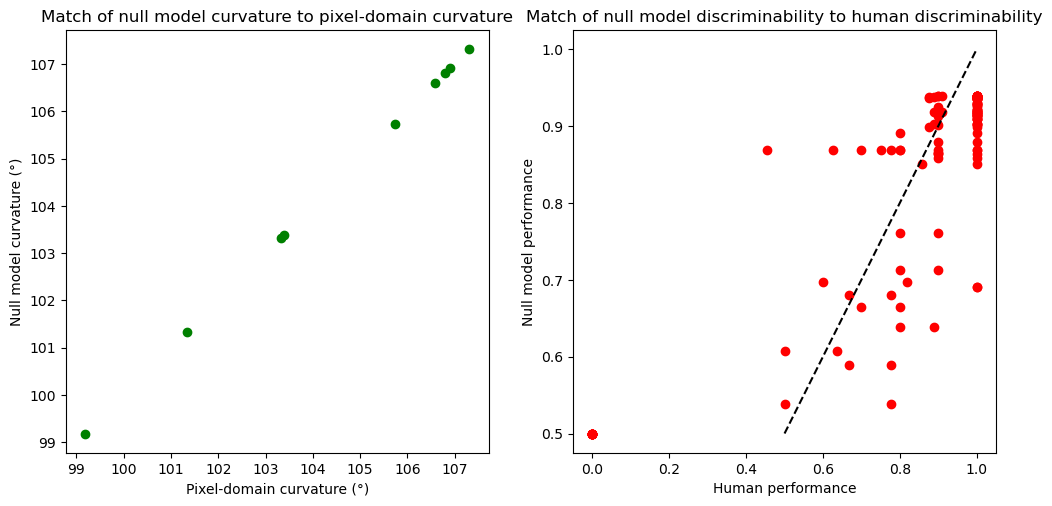

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Human performance')
axs[1].set_ylabel('Null model performance')
axs[1].set_box_aspect(1)

In [13]:
# TODO: run forward model to simulate data from observer model

### Run optimization

In [6]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 284.501811824739
Loss updated
Iteration 1 | Loss: 284.501811824739
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 2 | Loss: 286.6827395632863
Current loss: 332.42262878268957
Iteration 3 | Loss: 332.42262878268957
Current loss: 299.3117961138487
Iteration 4 | Loss: 299.3117961138487
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Iteration 5 | Loss: 375.64487501233816
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 6 | Loss: 312.27845149487257
Current loss: 278.5409882478416
Loss updated
Iteration 7 | Loss: 278.5409882478416
Current loss: 394.25969284772873
Iteration 8 | Loss: 394.25969284772873
Current loss: 352.08774061501026
Iteration 9 | Loss: 352.08774061501026
Current loss: 291.0601501464844
Iteration 10 | Loss: 291.0601501464844
Epoch: 0, Loss: 433.4881610107472
Epoch: 250, Loss: 417.0955214519927
Epoch: 500, Loss: 407.35653948834414
Epoch: 750, Loss: 396.7937162704852
Epoch: 1000, Loss: 382.3060728196223
Epoch:

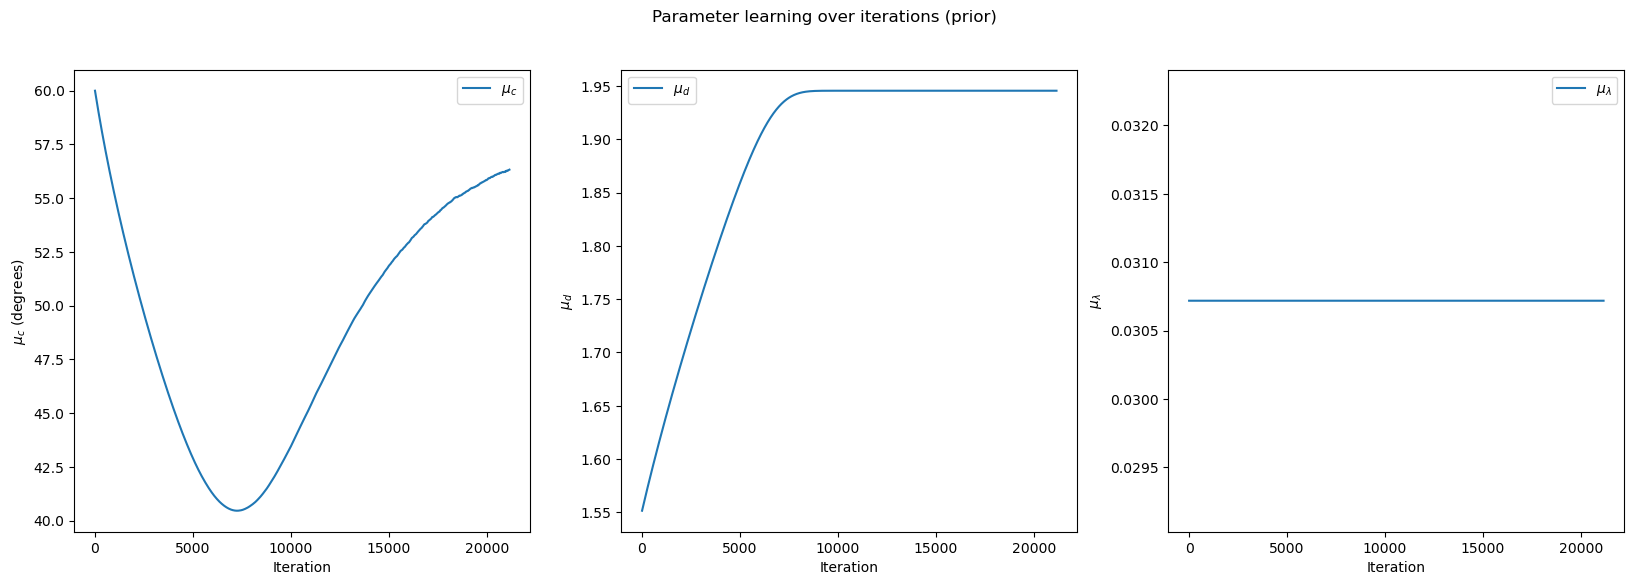

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_42303/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


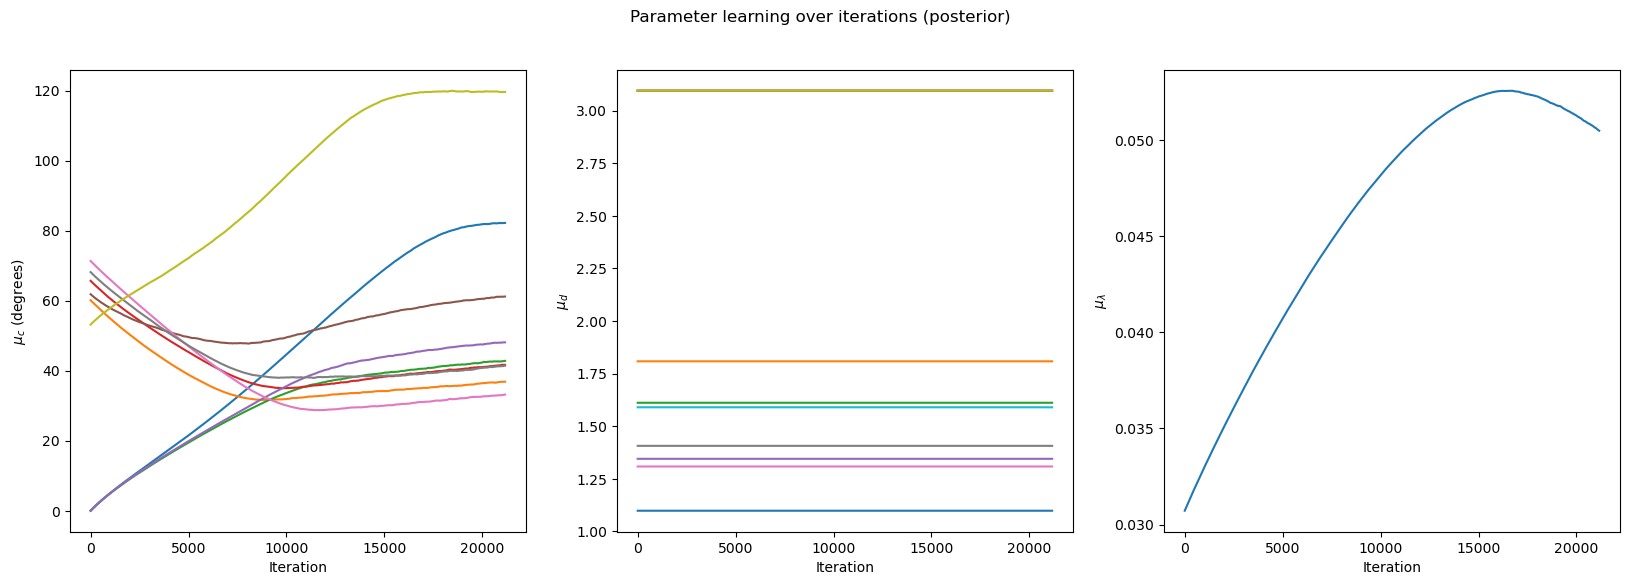

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [9]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 56.32330322265625 degrees
Average estimated local curvature: 56.32465134012828 degrees


### Analyze results

In [10]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

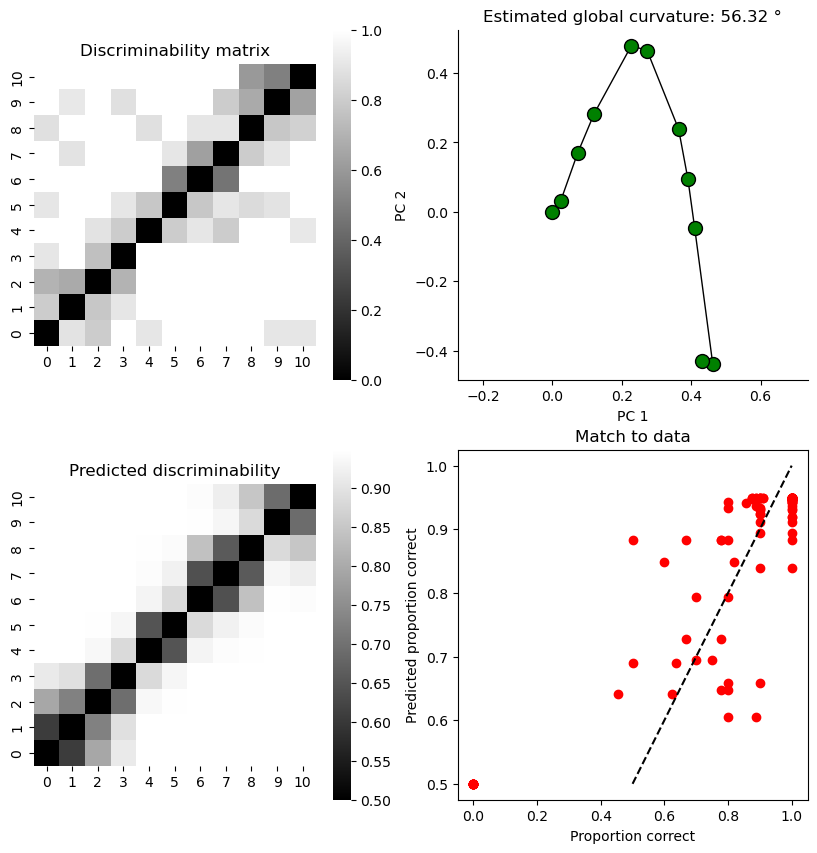

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()